# Recurrent Neural Network on Cifar-10 Datasets

Hello everyone and Prof Di Bo Ya. My name is Denzel Elden Wijaya, and in this notebook, I will demonstrate how to implement a Recurrent Neural Network on the Cifar-10 Datasets. I will extract the raw data and create a custom dataset class that inherits from `torch.utils.data.Dataset`. This custom dataset will then be passed to `torch.utils.data.DataLoader` to enable efficient data loading during training. We will also find out
1. How to feed images into an RNN Model
2. The effect of neuron number in the hidden layer
3. The number of hidden layers
4. Test both Vanilla RNN and LSTM, and the performance difference

The process will include these steps:
1. Load and Prepare the Dataset
2. Build the initial RNN Model
3. Model Experiment Testing
4. Conclusion

## 1. Load and Prepare the Dataset

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CifarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for file_name in os.listdir(class_path):
                    if file_name.endswith((".png", ".jpg", ".jpeg")):
                        self.image_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = CifarDataset(root_dir="/kaggle/input/cifar-dataset/cifar10_train", transform=transform)
test_dataset = CifarDataset(root_dir="/kaggle/input/cifar-dataset/cifar10_test", transform=transform)

cifar_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Total Training Data: {len(train_dataset)}")
print(f"Total Testing Data: {len(test_dataset)}")

Total Training Data: 50000
Total Testing Data: 10000


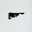

Label: airplane


In [3]:
# let's check the first image and its label

from IPython.display import display

image, label = train_dataset[1]
image = transforms.ToPILImage()(image)
display(image)

class_names = list(train_dataset.class_to_idx.keys())
label_name = class_names[label]

print(f"Label: {label_name}")

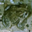

Label: frog


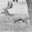

Label: deer


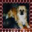

Label: dog


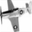

Label: airplane


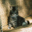

Label: cat


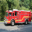

Label: truck


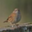

Label: bird


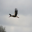

Label: bird


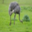

Label: bird


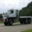

Label: truck


In [4]:
data_iter = iter(cifar_train_loader)
images, labels = next(data_iter)
for i in range(10):
    image = transforms.ToPILImage()(images[i])
    display(image)
    print(f"Label: {class_names[labels[i]]}")

## 2. Build the Initial RNN Model

Recurrent Neural Networks (RNNs) are a type of neural network designed to process sequential data. Unlike feedforward networks, RNNs have internal memory that allows them to retain information about previous inputs, making them well-suited for tasks like:

1. Text processing
2. Time-series forecasting
3. Audio analysis
4. And in this case, processing image rows as sequences

Although RNNs are typically used for sequential data like text, we can treat images as sequences. For example, a 32x32 RGB image can be seen as a sequence of 32 rows, each with 96 features (32 pixels × 3 channels).

In this initial experiment, we implemented a simple Recurrent Neural Network (RNN) model using PyTorch's nn.RNN module. The CIFAR-10 images are reshaped to be compatible with RNNs by treating each image as a sequence of 32 steps (rows), where each step is a 96-dimensional vector (32 pixels × 3 channels).

The RNN model configuration:
1. RNN type: Vanilla RNN
2. Number of layers: 1
3. Hidden size: 128
4. Activation: tanh (default in PyTorch RNN)
5. Output: Last time step → Fully Connected → 10 classes

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OnlyOneRNN(nn.Module):
    def __init__(self, input_size=96, hidden_size=128, num_classes=10):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = x.permute(0, 2, 3, 1).reshape(B, 32, -1)

        h_t = torch.zeros(B, self.hidden_size, device=x.device)

        for t in range(x.size(1)): 
            x_t = x[:, t, :]
            combined = torch.cat([x_t, h_t], dim=1)
            h_t = torch.tanh(self.i2h(combined))

        return self.fc(h_t)

In [17]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            running_loss += loss.item() * x.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total

In [18]:
device = torch.device("cuda")

model = OnlyOneRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 2.0749 Acc: 0.2300 | Test Loss: 1.9767 Acc: 0.2803
Epoch 2/10 | Train Loss: 2.0121 Acc: 0.2520 | Test Loss: 1.9662 Acc: 0.2624
Epoch 3/10 | Train Loss: 1.9502 Acc: 0.2792 | Test Loss: 1.9979 Acc: 0.2765
Epoch 4/10 | Train Loss: 1.8904 Acc: 0.3015 | Test Loss: 1.9278 Acc: 0.2829
Epoch 5/10 | Train Loss: 1.8521 Acc: 0.3209 | Test Loss: 1.8443 Acc: 0.3345
Epoch 6/10 | Train Loss: 1.7945 Acc: 0.3407 | Test Loss: 1.8251 Acc: 0.3256
Epoch 7/10 | Train Loss: 1.7617 Acc: 0.3514 | Test Loss: 1.7144 Acc: 0.3652
Epoch 8/10 | Train Loss: 1.7998 Acc: 0.3344 | Test Loss: 1.7655 Acc: 0.3526
Epoch 9/10 | Train Loss: 1.7476 Acc: 0.3549 | Test Loss: 1.6936 Acc: 0.3739
Epoch 10/10 | Train Loss: 1.7060 Acc: 0.3715 | Test Loss: 1.6666 Acc: 0.3860


While the model does learn something (as seen in the accuracy improvement), the performance plateaus around ~38% accuracy, which is quite low for CIFAR-10.

This suggests that:
1. The model cannot capture complex image patterns.
2. Vanilla RNN may not be expressive enough to model image data effectively.

But, before we change into LSTM, which supports a better result, let's experiment with the number of layers and the hidden size to find out the best model

## 3. Model Experiment Testing

#### Varying Hidden Size

We aim to investigate how increasing the RNN's hidden layer size affects the model’s ability to classify CIFAR-10 images. A larger hidden size allows the model to learn more complex representations, but it may also lead to longer training time or overfitting.

In [19]:
hidden_sizes = [64, 128, 256]

for hidden_size in hidden_sizes:
    print("Training RNN with hidden_size = {hidden_size}")

    model = OnlyOneRNN(input_size=96, hidden_size=hidden_size, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)

        print(f"Epoch {epoch+1}/10 | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")



🔥 Training RNN with hidden_size = 64
Epoch 1/10 | Train Loss: 2.0534 Acc: 0.2353 | Test Loss: 1.9242 Acc: 0.2950
Epoch 2/10 | Train Loss: 2.0260 Acc: 0.2507 | Test Loss: 1.9558 Acc: 0.2874
Epoch 3/10 | Train Loss: 1.9794 Acc: 0.2717 | Test Loss: 1.9241 Acc: 0.2827
Epoch 4/10 | Train Loss: 1.9085 Acc: 0.2981 | Test Loss: 1.8731 Acc: 0.3133
Epoch 5/10 | Train Loss: 1.8522 Acc: 0.3170 | Test Loss: 1.8044 Acc: 0.3391
Epoch 6/10 | Train Loss: 1.8305 Acc: 0.3260 | Test Loss: 2.0635 Acc: 0.2210
Epoch 7/10 | Train Loss: 1.9127 Acc: 0.2958 | Test Loss: 1.8741 Acc: 0.3086
Epoch 8/10 | Train Loss: 1.8531 Acc: 0.3157 | Test Loss: 1.8397 Acc: 0.3232
Epoch 9/10 | Train Loss: 1.8247 Acc: 0.3248 | Test Loss: 1.8072 Acc: 0.3258
Epoch 10/10 | Train Loss: 1.8249 Acc: 0.3254 | Test Loss: 1.8030 Acc: 0.3308

🔥 Training RNN with hidden_size = 128
Epoch 1/10 | Train Loss: 2.0936 Acc: 0.2224 | Test Loss: 2.2108 Acc: 0.2125
Epoch 2/10 | Train Loss: 2.0128 Acc: 0.2554 | Test Loss: 1.9968 Acc: 0.2532
Epoch 3/10

In [22]:
model = OnlyOneRNN(input_size=96, hidden_size=512, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)

    print(f"Epoch {epoch+1}/10 | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 2.1820 Acc: 0.1973 | Test Loss: 2.0618 Acc: 0.2293
Epoch 2/10 | Train Loss: 2.1569 Acc: 0.1961 | Test Loss: 2.1094 Acc: 0.2221
Epoch 3/10 | Train Loss: 2.1044 Acc: 0.2151 | Test Loss: 2.2211 Acc: 0.1620
Epoch 4/10 | Train Loss: 2.0975 Acc: 0.2191 | Test Loss: 2.0544 Acc: 0.2378
Epoch 5/10 | Train Loss: 2.1003 Acc: 0.2178 | Test Loss: 2.1692 Acc: 0.1721
Epoch 6/10 | Train Loss: 2.1760 Acc: 0.1903 | Test Loss: 2.1180 Acc: 0.1988
Epoch 7/10 | Train Loss: 2.1200 Acc: 0.2164 | Test Loss: 2.1374 Acc: 0.1947
Epoch 8/10 | Train Loss: 2.1212 Acc: 0.2178 | Test Loss: 2.1793 Acc: 0.1685
Epoch 9/10 | Train Loss: 2.1198 Acc: 0.2107 | Test Loss: 2.1848 Acc: 0.1980
Epoch 10/10 | Train Loss: 2.1582 Acc: 0.2010 | Test Loss: 2.2018 Acc: 0.1963


#### Varying Number of Layers

To examine how increasing the number of RNN layers (num_layers) affects the classification performance

In [7]:
device = torch.device("cuda")

import torch
import torch.nn as nn

class RNNRefined(nn.Module):
    def __init__(self, input_size=96, hidden_size=256, num_layers=1, num_classes=10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.i2h_layers = nn.ModuleList([
            nn.Linear(input_size + hidden_size, hidden_size)
        ])

        for _ in range(1, num_layers):
            self.i2h_layers.append(
                nn.Linear(hidden_size + hidden_size, hidden_size)
            )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # x: [B, 3, 32, 32]
        B = x.size(0)
        x = x.permute(0, 2, 3, 1).reshape(B, 32, -1)

        h = [torch.zeros(B, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        for t in range(x.size(1)):
            x_t = x[:, t, :]

            for l in range(self.num_layers):
                input_l = x_t if l == 0 else h[l - 1]
                combined = torch.cat([input_l, h[l]], dim=1)
                h[l] = torch.tanh(self.i2h_layers[l](combined))

        return self.fc(h[-1])



num_layers = [1,2,3]

for num_layer in num_layers:
    print(f"Training RNN with num_layers = {num_layer}")
    model = RNNRefined(input_size=96, hidden_size=256, num_layers=num_layer, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)
    
        print(f"Epoch {epoch+1}/10 | "
                f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Training RNN with num_layers = 1
Epoch 1/10 | Train Loss: 2.0763 Acc: 0.2259 | Test Loss: 2.0495 Acc: 0.2476
Epoch 2/10 | Train Loss: 1.9754 Acc: 0.2686 | Test Loss: 1.9495 Acc: 0.2654
Epoch 3/10 | Train Loss: 1.9134 Acc: 0.2965 | Test Loss: 2.0089 Acc: 0.2677
Epoch 4/10 | Train Loss: 1.9250 Acc: 0.2893 | Test Loss: 1.8885 Acc: 0.3014
Epoch 5/10 | Train Loss: 1.8230 Acc: 0.3205 | Test Loss: 1.8248 Acc: 0.3173
Epoch 6/10 | Train Loss: 1.7724 Acc: 0.3410 | Test Loss: 1.8328 Acc: 0.3241
Epoch 7/10 | Train Loss: 1.7608 Acc: 0.3477 | Test Loss: 1.7367 Acc: 0.3512
Epoch 8/10 | Train Loss: 1.7528 Acc: 0.3491 | Test Loss: 1.7584 Acc: 0.3390
Epoch 9/10 | Train Loss: 1.7764 Acc: 0.3466 | Test Loss: 1.6987 Acc: 0.3752
Epoch 10/10 | Train Loss: 1.7650 Acc: 0.3495 | Test Loss: 1.7252 Acc: 0.3594
Training RNN with num_layers = 2
Epoch 1/10 | Train Loss: 2.1620 Acc: 0.1999 | Test Loss: 2.0160 Acc: 0.2341
Epoch 2/10 | Train Loss: 2.1350 Acc: 0.2096 | Test Loss: 2.0240 Acc: 0.2677
Epoch 3/10 | Train Lo

#### Trying the LSTM Model

LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) that was specifically designed to overcome the limitations of standard (vanilla) RNNs — especially when it comes to learning long-range dependencies in sequential data.

Unlike vanilla RNNs, which often suffer from vanishing or exploding gradients, LSTM introduces gates (input, forget, and output) to control the flow of information, allowing the network to retain important context over time.

In this step, we keep the best setting from the previous RNN experiments:

1. hidden_size = 256
2. input_size = 96
3. Try num_layers = 2
4. No dropout (for now)

This will allow us to directly compare the impact of using LSTM instead of RNN under similar configurations.

In [10]:
import torch.nn as nn

import torch
import torch.nn as nn

class RNNwithLSTM(nn.Module):
    def __init__(self, input_size=96, hidden_size=256, num_classes=10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = x.permute(0, 2, 3, 1).reshape(B, 32, -1)

        h_t = torch.zeros(B, self.hidden_size, device=x.device)
        c_t = torch.zeros(B, self.hidden_size, device=x.device)

        for t in range(x.size(1)):
            x_t = x[:, t, :]

            gates = self.x2h(x_t) + self.h2h(h_t)
            i_gate, f_gate, o_gate, g_gate = gates.chunk(4, dim=1)

            i_t = torch.sigmoid(i_gate)
            f_t = torch.sigmoid(f_gate)
            o_t = torch.sigmoid(o_gate)
            g_t = torch.tanh(g_gate)

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

        return self.fc(h_t)


device = torch.device("cuda")

model = RNNwithLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 1.8032 Acc: 0.3348 | Test Loss: 1.6171 Acc: 0.4069
Epoch 2/10 | Train Loss: 1.5357 Acc: 0.4403 | Test Loss: 1.4415 Acc: 0.4678
Epoch 3/10 | Train Loss: 1.3768 Acc: 0.4991 | Test Loss: 1.3233 Acc: 0.5193
Epoch 4/10 | Train Loss: 1.2558 Acc: 0.5470 | Test Loss: 1.2609 Acc: 0.5451
Epoch 5/10 | Train Loss: 1.1470 Acc: 0.5888 | Test Loss: 1.1652 Acc: 0.5843
Epoch 6/10 | Train Loss: 1.0530 Acc: 0.6232 | Test Loss: 1.1329 Acc: 0.5990
Epoch 7/10 | Train Loss: 0.9703 Acc: 0.6524 | Test Loss: 1.1149 Acc: 0.6033
Epoch 8/10 | Train Loss: 0.8854 Acc: 0.6844 | Test Loss: 1.1001 Acc: 0.6100
Epoch 9/10 | Train Loss: 0.8062 Acc: 0.7136 | Test Loss: 1.0892 Acc: 0.6241
Epoch 10/10 | Train Loss: 0.7277 Acc: 0.7419 | Test Loss: 1.1067 Acc: 0.6174


Now, we see that we need dropout Layer to refine the result, and let's see how is the result when I try a different number of layers which is 3. And see how it works

In [13]:
class RNNModel(nn.Module):
    def __init__(self, input_size=96, hidden_size=256, num_layers=3, dropout=0.3, num_classes=10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.x2h = nn.ModuleList()
        self.h2h = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        for layer in range(num_layers):
            in_size = input_size if layer == 0 else hidden_size
            self.x2h.append(nn.Linear(in_size, 4 * hidden_size))
            self.h2h.append(nn.Linear(hidden_size, 4 * hidden_size))
            self.dropouts.append(nn.Dropout(dropout))

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # x: [B, 3, 32, 32]
        B = x.size(0)
        x = x.permute(0, 2, 3, 1).reshape(B, 32, -1)

        h = [torch.zeros(B, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        for t in range(x.size(1)):
            input_t = x[:, t, :]
            for layer in range(self.num_layers):
                gates = self.x2h[layer](input_t) + self.h2h[layer](h[layer])
                i_gate, f_gate, o_gate, g_gate = gates.chunk(4, dim=1)

                i = torch.sigmoid(i_gate)
                f = torch.sigmoid(f_gate)
                o = torch.sigmoid(o_gate)
                g = torch.tanh(g_gate)

                c[layer] = f * c[layer] + i * g
                h[layer] = o * torch.tanh(c[layer])

                input_t = self.dropouts[layer](h[layer])

        return self.fc(h[-1])


device = torch.device("cuda")

model = RNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 1.8265 Acc: 0.3212 | Test Loss: 1.6028 Acc: 0.4159
Epoch 2/10 | Train Loss: 1.5764 Acc: 0.4175 | Test Loss: 1.4894 Acc: 0.4476
Epoch 3/10 | Train Loss: 1.4282 Acc: 0.4790 | Test Loss: 1.3634 Acc: 0.5104
Epoch 4/10 | Train Loss: 1.3032 Acc: 0.5280 | Test Loss: 1.2758 Acc: 0.5399
Epoch 5/10 | Train Loss: 1.1891 Acc: 0.5732 | Test Loss: 1.1830 Acc: 0.5736
Epoch 6/10 | Train Loss: 1.1005 Acc: 0.6059 | Test Loss: 1.1242 Acc: 0.5995
Epoch 7/10 | Train Loss: 1.0186 Acc: 0.6330 | Test Loss: 1.1153 Acc: 0.6073
Epoch 8/10 | Train Loss: 0.9404 Acc: 0.6620 | Test Loss: 1.0987 Acc: 0.6128
Epoch 9/10 | Train Loss: 0.8679 Acc: 0.6882 | Test Loss: 1.0618 Acc: 0.6331
Epoch 10/10 | Train Loss: 0.7983 Acc: 0.7165 | Test Loss: 1.0717 Acc: 0.6312


In [19]:
class RNNModel(nn.Module):
    def __init__(self, input_size=96, hidden_size=256, num_layers=4, dropout=0.4, num_classes=10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.x2h = nn.ModuleList()
        self.h2h = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        for layer in range(num_layers):
            in_size = input_size if layer == 0 else hidden_size
            self.x2h.append(nn.Linear(in_size, 4 * hidden_size))
            self.h2h.append(nn.Linear(hidden_size, 4 * hidden_size))
            self.dropouts.append(nn.Dropout(dropout))

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # x: [B, 3, 32, 32]
        B = x.size(0)
        x = x.permute(0, 2, 3, 1).reshape(B, 32, -1)

        h = [torch.zeros(B, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        for t in range(x.size(1)):
            input_t = x[:, t, :]
            for layer in range(self.num_layers):
                gates = self.x2h[layer](input_t) + self.h2h[layer](h[layer])
                i_gate, f_gate, o_gate, g_gate = gates.chunk(4, dim=1)

                i = torch.sigmoid(i_gate)
                f = torch.sigmoid(f_gate)
                o = torch.sigmoid(o_gate)
                g = torch.tanh(g_gate)

                c[layer] = f * c[layer] + i * g
                h[layer] = o * torch.tanh(c[layer])

                input_t = self.dropouts[layer](h[layer])

        return self.fc(h[-1])


device = torch.device("cuda")

model = RNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, cifar_train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, cifar_test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 1.8382 Acc: 0.3185 | Test Loss: 1.6993 Acc: 0.3677
Epoch 2/10 | Train Loss: 1.5735 Acc: 0.4199 | Test Loss: 1.4725 Acc: 0.4516
Epoch 3/10 | Train Loss: 1.4331 Acc: 0.4756 | Test Loss: 1.3595 Acc: 0.5014
Epoch 4/10 | Train Loss: 1.3176 Acc: 0.5267 | Test Loss: 1.2702 Acc: 0.5351
Epoch 5/10 | Train Loss: 1.2158 Acc: 0.5630 | Test Loss: 1.1795 Acc: 0.5745
Epoch 6/10 | Train Loss: 1.1299 Acc: 0.5964 | Test Loss: 1.1935 Acc: 0.5800
Epoch 7/10 | Train Loss: 1.0574 Acc: 0.6223 | Test Loss: 1.1034 Acc: 0.6047
Epoch 8/10 | Train Loss: 0.9932 Acc: 0.6450 | Test Loss: 1.0653 Acc: 0.6253
Epoch 9/10 | Train Loss: 0.9250 Acc: 0.6675 | Test Loss: 1.0738 Acc: 0.6281
Epoch 10/10 | Train Loss: 0.8754 Acc: 0.6888 | Test Loss: 1.0274 Acc: 0.6408


After tuning several hyperparameters including `hidden_size`, `num_layers`, and `dropout`, the best performing configuration was:

- **Model**: LSTM
- **Hidden Size**: 256
- **Num Layers**: 4
- **Dropout**: 0.4
- **Epochs**: 10

### Final Performance:
- **Training Accuracy**: 68.88%
- **Test Accuracy**: **64.08%**

This setup achieved the highest generalization performance across all experiments, confirming that LSTM with moderate depth and dropout provides the best balance between learning capacity and regularization.

## 4. Conclusion

After a series of experiments, we evaluated how different architectural choices affect the classification performance of RNN-based models (Vanila RNN and LSTM) on image data. Below are the key takeaways:

1.	Effect of Increasing Hidden Size:
Increasing the hidden_size from 64 to 256 significantly improved the model’s ability to learn richer representations:

- hidden_size = 64: Model underfit with test accuracy around 33%
- hidden_size = 256: Achieved the best performance (~42%) with Vanilla RNN
- hidden_size = 512: Performance degraded drastically due to over-parameterization, leading to unstable training
- 
Conclusion: There is an optimal range of hidden size — beyond that, model complexity hurts performance without regularization.

2.	Effect of Increasing Number of RNN Layers:
Adding more RNN layers showed diminishing returns in Vanilla RNN:
- Num_layers = 1: Solid baseline
- Num_layers = 2: Gets slight improvement
- Num_layers = 3: Accuracy collapsed, indicating vanishing gradients or training instability
Conclusion: Deep vanilla RNNs are unstable without advanced mechanisms like LSTM.

3.	Why LSTM Performs Better
Replacing Vanilla RNN with LSTM led to:
- Higher stability during training
- Better generalization with no sudden performance drop
- Gradual increase in test accuracy up to 61%
This is due to LSTM's internal gating mechanisms, which preserve long-term information and mitigate the vanishing gradient problem.

4.	Final LSTM with 4 Layers & Dropout
Unlike Vanilla RNN, the LSTM model benefited from a deeper architecture:
- num_layers = 4 with dropout=0.4 achieved high training and testing performance
- Overfitting was reduced, and test accuracy was maintained
Conclusion: LSTM supports deeper architectures and benefits from dropout regularization, making it more scalable and robust than Vanilla RNN.


That will wrap up my code in this notebook, thank you for your attention.